# 安全帽检测

## 1.项目说明

在该项目中，主要向大家介绍如何使用目标检测来实现对安全帽的检测，涉及代码以及优化过程亦可用于其它目标检测任务等。

在施工现场，对于来往人员，以及工作人员而言，安全问题至关重要。而安全帽更是保障施工现场在场人员安全的第一防线，因此需要对场地中的人员进行安全提醒。当人员未佩戴安全帽进入施工场所时，人为监管耗时耗力，而且不易实时监管，过程繁琐、消耗人力且实时性较差。针对上述问题，希望通过**视频监控->目标检测->智能督导**的方式智能、高效的完成此任务。

如需更多技术交流与合作，欢迎扫码加入交流群：

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/4c9b2980e73741189b75195bb2431a4190c36556b180435386c7605a1e9d8ded"  width = "320" />

<p><b><font size="4">
  5月12日晚19:00，我们将在线分享安全帽检测方案详解和避坑指南，30分钟直达产业项目落地！
欢迎大家扫码报名直播课，如有更多技术交流与合作，也欢迎大家扫码进群。</font>
</p></b>
</div>
  
<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/2a157e40a9504cc0a4444bad2ef9d551b887bf01618c492c8ed6f132aed3a9bc"  width = "800" />
</div>

**业务难点：**

- **精度要求高** 由于涉及安全问题，需要精度非常高才能保证对施工场所人员的安全督导。需要专门针对此目标的检测算法进行优化。
- **精度要求高** 监控受拍摄角度、光线变化、天气影响，有时会存在遮挡，导致安全帽显示不全，对检测具有一定的干扰。
- **小目标检测** 由于实际使用过程中，人员离镜头较远，因此需要模型对小目标的检测有较低的漏检率。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/4733df36e84947d7bd1dc5015d0676c5c67b1bb6ae8f4b399fb60e169bd44449"  width = "1024" /></div>


## 2.数据准备

数据集中包含了5000张已经标注好的数据。该项目采用目标检测的标注方式，在本文档中提供了VOC数据集格式。

解压项目提供的数据：

In [ ]:
!unzip  /home/aistudio/data/data50329/HelmetDetection.zip -d /home/aistudio/work/dataset

更改一下命名:
```
dataset/                          dataset/
  ├── annotations/      -->         ├── Annotations/
  ├── images/                       ├── JPEGImages/
```

In [ ]:
%cd /home/aistudio/work/dataset
%mv annotations Annotations
%mv images JPEGImages

数据集分类情况: **`head` , `helmet`, `person`.**

更多数据格式信息请参考[数据标注说明文档](https://paddlex.readthedocs.io/zh_CN/develop/data/annotation/index.html)

安装PaddleX:

In [ ]:
!pip install paddlex

- **数据切分** 将训练集和验证集按照8.5：1.5的比例划分。 PaddleX中提供了简单易用的API，方便用户直接使用进行数据划分。

In [ ]:
!paddlex --split_dataset --format voc --dataset_dir /home/aistudio/work/dataset --val_value 0.15

```
dataset/                          dataset/
  ├── Annotations/      -->         ├── Annotations/
  ├── JPEGImages/                   ├── JPEGImages/
                                    ├── labels.txt
                                    ├── train_list.txt
                                    ├── val_list.txt
```

## 3.模型选择

PaddleX提供了丰富的视觉模型，在目标检测中提供了RCNN和YOLO系列模型。在本项目中采用YOLO作为检测模型进行安全帽检测。

## 4. 模型训练

在本项目中，采用YOLOV3作为安全帽检测的基线模型，以COCO指标作为评估指标。具体代码请参考[train.py](./code/train.py)

运行如下代码开始训练模型：

In [ ]:
# 单卡训练
%cd /home/aistudio/
!python /home/aistudio/code/train.py

In [ ]:
# 四卡训练
%cd /home/aistudio/
!export CUDA_VISIBLE_DEVICES=0,1,2,3
!python -m paddle.distributed.launch --gpus 0,1,2,3 /home/aistudio/code/train.py

- 训练过程说明

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/b167cd449a82414982f228220c64b51dd9830a361d9d4e9ba7f4a8e8a103a78a"  width = "1024" /></div>


## 5.模型优化(进阶)

- 精度提升 为了进一步提升模型的精度，可以通过**coco_error_analysis**

### 精度优化思路分析

本小节侧重展示在模型迭代过程中优化精度的思路，在本案例中，有些优化策略获得了精度收益，而有些没有。在其他场景中，可根据实际情况尝试这些优化策略。
 
### (1) 基线模型选择

相较于二阶段检测模型，单阶段检测模型的精度略低但是速度更快。考虑到是部署到GPU端，本案例选择单阶段检测模型YOLOV3作为基线模型，其骨干网络选择DarkNet53。训练完成后，模型在验证集上的精度如下:

| 模型                                                         | 推理时间 （ms/image） | map(Iou-0.5) | (coco)mmap | 安全帽AP(Iou-0.5) |
| ------------------------------------------------------------ | :-------------------: | ------------ | :--------: | :---------------: |
| baseline: YOLOv3 + DarkNet53 + cluster_yolo_anchor + img_size(480) |         50.34         | 61.6         |    39.2    |       94.58       |




### (2) 基线模型效果分析与优化

使用PaddleX提供的[paddlex.det.coco_error_analysis](https://paddlex.readthedocs.io/zh_CN/develop/apis/visualize.html#paddlex-det-coco-error-analysis)接口对模型在验证集上预测错误的原因进行分析，分析结果以图表的形式展示如下：

| allclass                                    | head                                         | person                                       | helmet                                       |
| ------------------------------------------- | -------------------------------------------- | -------------------------------------------- | -------------------------------------------- |
| <img src="https://ai-studio-static-online.cdn.bcebos.com/f210e3ad4cf04a02b69ffbcfe27ab502dc0cfbfeef244c16a5733483cf2ae494"  width = "320" /> | <img src="https://ai-studio-static-online.cdn.bcebos.com/d6be0d72e78748ce85585c3ee5775e16d1dff943ddf44e4086de68f3a64daecf"  width = "320" /> | <img src="https://ai-studio-static-online.cdn.bcebos.com/463dfb59eaa4412bbf30e629e66a4042dfd4d32c327649e48bdffdd0b741e10d"  width = "320" /> | <img src="https://ai-studio-static-online.cdn.bcebos.com/33fbc2fabbec4411a5685b87d51fe38b9b7e22cae88a4985b5221a764e342407"  width = "320" /> |

分析图表展示了7条Precision-Recall（PR）曲线，每一条曲线表示的Average Precision （AP）比它左边那条高，原因是逐步放宽了评估要求。以helmet类为例，各条PR曲线的评估要求解释如下：

- C75: 在IoU设置为0.75时的PR曲线, AP为0.681。
- C50: 在IoU设置为0.5时的PR曲线，AP为0.946。C50与C75之间的白色区域面积代表将IoU从0.75放宽至0.5带来的AP增益。
- Loc: 在IoU设置为0.1时的PR曲线，AP为0.959。Loc与C50之间的蓝色区域面积代表将IoU从0.5放宽至0.1带来的AP增益。蓝色区域面积越大，表示越多的检测框位置不够精准。
- Sim: 在Loc的基础上，如果检测框与真值框的类别不相同，但两者同属于一个亚类，则不认为该检测框是错误的，在这种评估要求下的PR曲线, AP为0.961。Sim与Loc之间的红色区域面积越大，表示子类间的混淆程度越高。VOC格式的数据集所有的类别都属于同一个亚类。
- Oth: 在Sim的基础上，如果检测框与真值框的亚类不相同，则不认为该检测框是错误的，在这种评估要求下的PR曲线，AP为0.961。Oth与Sim之间的绿色区域面积越大，表示亚类间的混淆程度越高。VOC格式的数据集中所有的类别都属于同一个亚类，故不存在亚类间的混淆。
- BG: 在Oth的基础上，背景区域上的检测框不认为是错误的，在这种评估要求下的PR曲线，AP为0.970。BG与Oth之间的紫色区域面积越大，表示背景区域被误检的数量越多。
- FN: 在BG的基础上，漏检的真值框不认为是错误的，在这种评估要求下的PR曲线，AP为1.00。FN与BG之间的橙色区域面积越大，表示漏检的真值框数量越多。

从分析图表中可以看出，head、helmet两类检测效果较好，但仍然存在漏检的情况，特别是person存在很大的漏检问题；此外，通过helmet中C75指标可以看出，其相对于C50的0.946而言有些差了，因此定位性能有待进一步提高。为进一步理解造成这些问题的原因，将验证集上的预测结果进行了可视化，然后发现数据集标注存在以下问题：

- 本数据集主要考虑到头部和安全帽的检测，因此在人检测时，有个图片中标注了，而有的图片中没有标注，从而导致学习失效，引发person漏检。
- head与helmet大多数情况标注较好，但由于部分拍摄角度导致有的图片中的head和helmet发生重叠以及太小导致学习有困难。

考虑到漏检问题，一般是特征学习不够，无法识别出物体，因此基于这个方向，尝试替换backbone: DarkNet53 --> ResNet50_vd_dcn，在指标上的提升如下:

| 模型                                                         | 推理时间 （ms/image） | map(Iou-0.5) | (coco)mmap | 安全帽AP(Iou-0.5) |
| ------------------------------------------------------------ | :-------------------: | ------------ | :--------: | :---------------: |
| YOLOv3 + ResNet50_vd_dcn + cluster_yolo_anchor+img_size(480) |         53.81         | **61.7**     |    39.1    |     **95.35**     |

考虑到定位问题，通过尝试放大图片，不同的网络结构以及定位的优化策略: 利用`cluster_yolo_anchor`生成聚类的anchor或开启iou_aware。最终得到上线模型PPYOLOV2的精度如下:

| 模型                                           | 推理时间 （ms/image） | map(Iou-0.5) | (coco)mmap | 安全帽AP(Iou-0.5) |
| ---------------------------------------------- | :-------------------: | ------------ | :--------: | :---------------: |
| **PPYOLOV2 + ResNet50_vd_dcn + img_size(608)** |         81.52         | 61.6         |  **41.3**  |       95.32       |

其中helmet类误差分析如下图:

<div align="center">
    <img src="https://ai-studio-static-online.cdn.bcebos.com/33fbc2fabbec4411a5685b87d51fe38b9b7e22cae88a4985b5221a764e342407"  width = "640" />
</div>


从分析表中可以看出:

- C75指标效果明显改善，定位更加准确：**从0.681提升到0.742**。
- 其中BG到FN的差距**从0.03降低到了0.02**，说明漏检情况有所改善。
- 其中Loc与Sim的差距**从0.002降低到了0.001**，说明混淆程度也下降了。
- 其中Oth与BG的差距**从0.019降低到了0.015**，说明检测错误下降了。

本项目优化整体分析可归纳为以下几点:

- 通过选用适当更优的骨干网络可以改善漏检的情况，因此漏检方面的优化可以考虑先从骨干网络替换上开始——当然必要的数据清洗也是不可缺少的，要是数据集本身漏标，则会从根本上影响模型的学习。
- 通过放大图像，可以对一些中小目标的物体检测起到一定的优化作用。
- 通过聚类anchor以及iou_aware等操作可以提高模型的定位能力，直接体现是再高Iou上也能有更好的表现。【因此，定位不准可以从模型的anchor以及模型的结构上入手进行优化】

### (3) 数据增强选择

|                       训练预处理1(a1)                        |                          验证预处理                          |
| :----------------------------------------------------------: | :----------------------------------------------------------: |
|                  MixupImage(mixup_epoch=-1)                  |           Resize(target_size=480, interp='CUBIC')            |
|                       RandomDistort()                        | Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) |
|   RandomExpand(im_padding_value=[123.675, 116.28, 103.53])   |                                                              |
|                         RandomCrop()                         |                                                              |
|                    RandomHorizontalFlip()                    |                                                              |
| BatchRandomResize(target_sizes=[320, 352, 384, 416, 448, 480, 512, 544, 576, 608],interp='RANDOM') |                                                              |
| Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) |                                                              |

在加入了[RandomHorizontalFlip](https://paddlex.readthedocs.io/zh_CN/develop/apis/transforms/det_transforms.html#randomhorizontalflip)、[RandomDistort](https://paddlex.readthedocs.io/zh_CN/develop/apis/transforms/det_transforms.html#randomdistort)、[RandomCrop](https://paddlex.readthedocs.io/zh_CN/develop/apis/transforms/det_transforms.html#randomcrop)、[RandomExpand](https://paddlex.readthedocs.io/zh_CN/develop/apis/transforms/det_transforms.html#randomexpand)、[BatchRandomResize](https://paddlex.readthedocs.io/zh_CN/develop/apis/transforms/det_transforms.html#batchrandomresize)、[MixupImage](https://paddlex.readthedocs.io/zh_CN/develop/apis/transforms/det_transforms.html#mixupimage)这几种数据增强方法后，对模型的优化是有一定的积极作用了，在取消这些预处理后，模型性能会有一定的下降。

**PS**：建议在训练初期都加上这些预处理方法，到后期模型超参数以及相关结构确定最优之后，再进行数据方面的再优化: 比如数据清洗，数据预处理方法筛选等。



>


## 6优化结论

采用PaddleX在Tesla V100上测试模型的推理时间（输入数据拷贝至GPU的时间、计算时间、数据拷贝至CPU的时间），推理时间如下表所示：（十次推理取平均耗时）

| 模型                                                         | 推理时间 （ms/image） | map(Iou-0.5) | (coco)mmap | 安全帽AP(Iou-0.5) |
| ------------------------------------------------------------ | :-------------------: | ------------ | :--------: | :---------------: |
| baseline: YOLOv3 + DarkNet53 + cluster_yolo_anchor + img_size(480) |         50.34         | 61.6         |    39.2    |       94.58       |
| YOLOv3 + ResNet50_vd_dcn + cluster_yolo_anchor+img_size(480) |         53.81         | 61.7         |    39.1    |       95.35       |
| PPYOLO + ResNet50_vd_dcn + iou_aware + img_size(480)     |         72.88         | 62.4     |    37.7    |     95.73     |
| **PPYOLO + ResNet50_vd_dcn + label_smooth=True + iou_aware + img_size(480)**     |         72.76         | **63.5**     |    **40.6**    |     **96.83**     |
| PPYOLO + ResNet50_vd_dcn + cluster_yolo_anchor + img_size(480) |         67.14         | 61.8         |    39.8    |       95.08       |
| **PPYOLOV2 + ResNet50_vd_dcn + img_size(608)**               |         81.52         | 61.6         |  **41.3**  |       95.32       |
| PPYOLOV2 + ResNet101_vd_dcn + img_size(608)                  |        106.62         | 61.3         |    40.6    |       95.15       |
|                                                              |                       |              |            |                   |

注意:

- **608**的图像大小，一般使用默认的anchors进行训练和推理即可。
- **cluster_yolo_anchor**: 用于生成拟合数据集的模型anchor。
- **label_smooth**: 通常用于当模型能够较好的拟合训练集时，进行正则化处理，提高训练模型的泛化能力——即测试/评估精度。

```
anchors = train_dataset.cluster_yolo_anchor(num_anchors=9, image_size=480)
anchor_masks = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
```


**优化进展说明**：

- 1.通过选择**更好的backbone**作为特征提取的骨干网络可以提高识别率、降低漏检率。<**DarkNet53 到 ResNet50_vd_dcn**>

- 2.通过选择更好的检测架构可以提高检测的mmap值——即**Neck，Head部分的优化**可以提高ap。<**YOLOV3 到 PPYOLOV2**>

- 3.缩放适当的图像大小可以提高模型的识别率，但是存在一定的阈值——当图像大小到某一个阈值时会导致精度下降。

  - **一般图像大小选择(YOLO系列)**:320，480， 608。
  - 一般**图像如果较大，物体也比较大**，可以较为放心的缩小图像大小再进行相关的训练和预测。
  - 物体较小，不易缩小，**可以适当的裁剪划分原图或放大**，并处理对应的标注数据，再进行训练。

  <**480到608**>

- 4.通过cluster_yolo_anchor生成当前网络输入图像大小下拟合数据集的预置anchors，利用新生成的anchors替换原来的默认anchor，使得模型预测定位上框选**位置更准确**。

- 5.通过PPYOLO两个实验，一个使用**iou_aware**，一个不是使用**iou_aware**而采用聚类得到的**anchor**提高定位能力；分析数据发现在定位信息优化上，**iou_aware**在当前数据集上表现更好，但推理时间也有所提升。

- 6.通过PPYOLO两个实验，一个使用**label_smooth**，一个不使用，分析出使用**label_smooth**可以让模型在**验证集**上表现更好了。

- 通过以上的简单优化方式，获取了两个较好的模型结果:

- | 模型                                           | 推理时间 （ms/image） | map(Iou-0.5) | (coco)mmap | 安全帽AP(Iou-0.5) |
  | ---------------------------------------------- | :-------------------: | ------------ | :--------: | :---------------: |
  | **PPYOLO + ResNet50_vd_dcn + label_smooth=True + iou_aware + img_size(480)**   |         72.76         | **63.5**     |    **40.6**    |     **96.83**     |
  | **PPYOLOV2 + ResNet50_vd_dcn + img_size(608)** |         81.52         | 61.6         |  **41.3**  |       95.32       |



## 7.模型预测
运行如下代码：

In [ ]:
!python code/infer.py

则可生成result.txt文件并显示预测结果图片，result.txt文件中会显示图片中每个检测框的位置、类别及置信度, 从而实现了安全帽的自动检测。

预测结果如下：

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/6b743e42444a4459bbb5ed2c39dc5649da2421fd79294a06b5584f64d3bddd14"  width = "800" />

## 8.模型导出

模型训练后保存在output文件夹，如果要使用PaddleInference进行部署需要导出成静态图的模型,运行如下命令，会自动在output文件夹下创建一个`inference_model`的文件夹，用来存放导出后的模型。

In [ ]:
!paddlex --export_inference --model_dir=/home/aistudio/models/yolov3_darknet53 \
         --save_dir=output/inference_model --fixed_input_shape=[480,480]

基于导出的模型，在单张图像上做推理：

In [ ]:
import paddlex as pdx
predictor = pdx.deploy.Predictor('/home/aistudio/output/inference_model/inference_model')
img_path = '/home/aistudio/work/97ce96584315ba13a4927c8a0.jpg'
result = predictor.predict(img_file=img_path)
print(result)

可视化：

2022-05-11 11:11:49 [INFO]	The visualized result is saved at /home/aistudio/visualize_97ce96584315ba13a4927c8a0.jpg


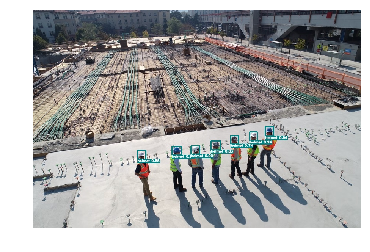

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt # plt 用于显示图片
import numpy as np
import cv2
import os

save_dir='/home/aistudio/'
pdx.det.visualize(img_path, result, save_dir=save_dir)

path,filename = os.path.split(img_path)
output_path = os.path.join(save_dir,"visualize_"+filename)

pic = cv2.imread(output_path)
pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
plt.imshow(pic)
plt.axis('off') # 不显示坐标轴
plt.show()

对视频数据抽帧进行检测：

In [ ]:
import cv2
import paddlex as pdx
import numpy as np
import colorsys
import os

predictor = pdx.deploy.Predictor('/home/aistudio/output/inference_model/inference_model')
cap = cv2.VideoCapture('/home/aistudio/work/Industry.mp4')
save_dir='/home/aistudio/frames'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
i = 1
det_rate = 20
save_dir = "/home/aistudio/frames/"
while cap.isOpened():
    ret, frame = cap.read()
    if ret :
        if i%det_rate==0:
            result = predictor.predict(frame)
            print(i)
            vis_img = pdx.det.visualize(frame, result, save_dir=save_dir)
            
            # 本地环境可以实时查看安全帽检测效果
            # cv2.imshow('hatdet', vis_img)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
        i += 1
    else:
        break
cap.release()

**注意**：设定 fixed_input_shape 的数值需与 eval_transforms 中设置的 target_size 数值上保持一致。

## 9.模型上线选择

本案例面向GPU端的最终方案是选择一阶段检测模型PPYOLOV2，其骨干网络选择加入了可变形卷积（DCN）的ResNet50_vd，训练阶段数据增强策略采用RandomHorizontalFlip、RandomDistort、RandomCrop等。

在Tesla V100的Linux系统下，模型的推理时间大约为81.52ms/image，包括transform、输入数据拷贝至GPU的时间、计算时间、数据拷贝至CPU的时间。

| 模型                                       | 推理时间 (ms/image) | map(Iou-0.5) | (coco)mmap | 安全帽AP(Iou-0.5) |
| ------------------------------------------ | ------------------- | ------------ | :--------: | :---------------: |
| PPYOLOV2 + ResNet50_vd_dcn + img_size(608) | 81.52               | 61.6         |    41.3    |       95.32       |
|                                            |                     |              |            |                   |

**上线模型的PR曲线:**

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/bebb2b4e89f74701b59b2ce395cbd57ca2e0c1c8f1f647f7897e732c742fe55f"  width = "1024" /></div>


在本项目中的安全帽检测数据中，标注信息本身存在一定的缺漏，导致部分类别学习失效。但针对本项目的安全帽检测问题而言，**person(人)这一类别影响不大，因此可以在mmap较大的基础上主要看helmet(安全帽)的精度即可**。通过**COCO的评估指标**，可以使多类别的检测模型的评估更加符合实际应用；虽然我们可以看出在该数据集中，有一个类别对整体的map与mmap有较大影响，但是通过COCO指标能够取得一个相对数据集更**综合表现**(不同Iou尺度下)的一个模型。

**注意**: 通过VOC指标也许能够取得更好的Iou-0.5指标下更好的数据，但是却会使得对多Iou尺度的一个评估，使得得到该评估指标下最好的模型未必在其它Iou尺度下也有最好的表现。



## 10.模型部署方式

### 10.1 Jetson设备C++ inference部署

模型部署采用了PaddleX提供的C++ inference部署方案，在该方案中提供了在端侧设备Jetson部署[Demo](https://github.com/cjh3020889729/The-PaddleX-QT-Visualize-GUI/tree/main/deploy/cpp/docs/jetson_deploy)，用户可根据实际情况自行参考。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/3f5c50f3f53548b2a3fa59e6b51bbc023fa4a39318774e2a841d3d923c0e12de"  width = "1024" /></div>


### 10.2 PaddleHub轻量级服务化部署
借助PaddleHub-Serving，可以将PaddleX的Inference Model进行快速部署，以提供在线预测的能力。参考链接：[https://paddlex.readthedocs.io/zh_CN/release-1.3/deploy/hub_serving.html](https://paddlex.readthedocs.io/zh_CN/release-1.3/deploy/hub_serving.html)。

更新PaddleHub版本：``

In [ ]:
!pip install --upgrade paddlehub -i https://pypi.tuna.tsinghua.edu.cn/simple

将PaddleX的Inference Model转换成PaddleHub的预训练模型，使用命令hub convert即可一键转换：

In [12]:
!hub convert --model_dir /home/aistudio/output/inference_model/inference_model --module_name helmet_hub

The converted module is stored in `helmet_hub_1652238760.0615911`.


模型转换后，得到`helmet_hub.tar.gz`压缩包，在进行部署之前需要先安装到本机，使用命令hub install即可一键安装：

In [ ]:
!hub install helmet_hub_1652166294.6532774/helmet_hub.tar.gz

接下来，只需要使用`hub serving`命令即可完成模型的一键部署：

In [ ]:
!hub serving start -m helmet_hub

客户端请求：

In [ ]:
# coding: utf8
import requests
import json
import cv2
import base64


def cv2_to_base64(image):
    data = cv2.imencode('.jpg', image)[1]
    return base64.b64encode(data.tostring()).decode('utf8')


if __name__ == '__main__':
    # 获取图片的base64编码格式
    img1 = cv2_to_base64(cv2.imread("/home/aistudio/work/97ce96584315ba13a4927c8a0.jpg"))
    data = {'images': [img1]}
    # 指定content-type
    headers = {"Content-type": "application/json"}
    # 发送HTTP请求
    url = "http://127.0.0.1:8866/predict/helmet_hub"
    r = requests.post(url=url, headers=headers, data=json.dumps(data))

    # 打印预测结果
    print(r.json()["results"])